# Proyecto Máquinas de Aprendizaje
## Predicción de Incendios Forestales utilizando técnicas de Máquinas de Aprendizaje
### Daniel San Martín

Este proyecto tiene como objetivo analizar el trabajo desarrollado en el artículo "**A Data Mining Approach to Predict Forest Fires using Meteorological Data**" de Paulo Cortez y Aníbal Morais. Para esto se realiza una comparación, análisis y propuesta de modelos sobre el trabajo desarrollado por los autores mencionados.

In [330]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data manipulation

# Models
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neural_network import MLPRegressor as MLPR
from sklearn.svm import SVR

# Tools 
from sklearn.preprocessing import MinMaxScaler, StandardScaler # data pre-processing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # regression metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV # tools
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt # plots
import pandas.plotting as pdplt

import warnings
warnings.filterwarnings('ignore')

## Pre-procesamiento de datos

Los datos utilizados en este trabajo fueron extraidos del parque natural de Montesinho, en Trás-os-Montes región del noreste de Portugal, y contienen información sobre las áreas de terreno quemada en episodios de incendios entre enero del 2000 y diciembre del 2003.

In [178]:
# Load data
df = pd.read_csv("./data/forestfires.csv", sep = ",",header = 0)

# Categorize month and days
df.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)
df.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)

# Data information
print("Shape: ", df.shape)
df.info()
df.describe()

Shape:  (517, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null int64
day      517 non-null int64
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(5)
memory usage: 52.6 KB


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,1.000000,1.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,9.000000,6.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,12.000000,7.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


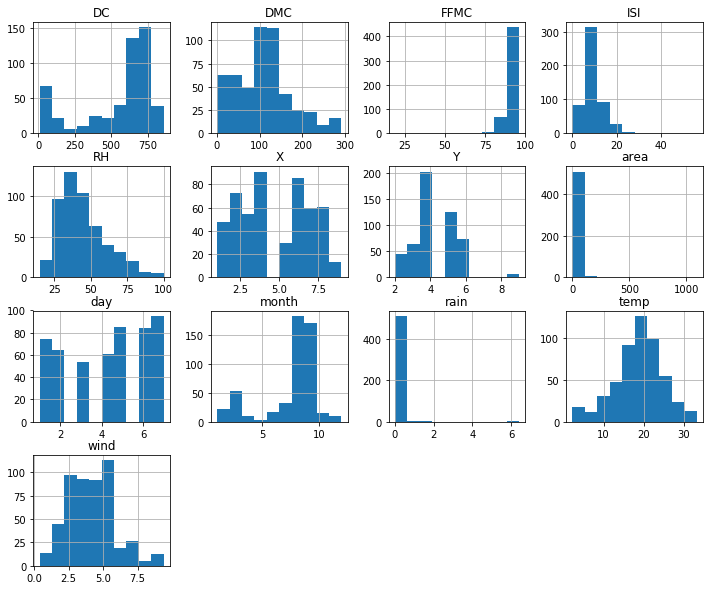

In [179]:
df.hist(figsize=(12, 10))
plt.show()

In [180]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    mat = ax.matshow(corr)
    plt.title("Correlation Matrix")
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.colorbar(mat)
    plt.show()

In [181]:
df.corr()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.063385
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.044873
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.056496
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,0.023226
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.040122
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.072994
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.049383
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,0.008258
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.097844
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.075519


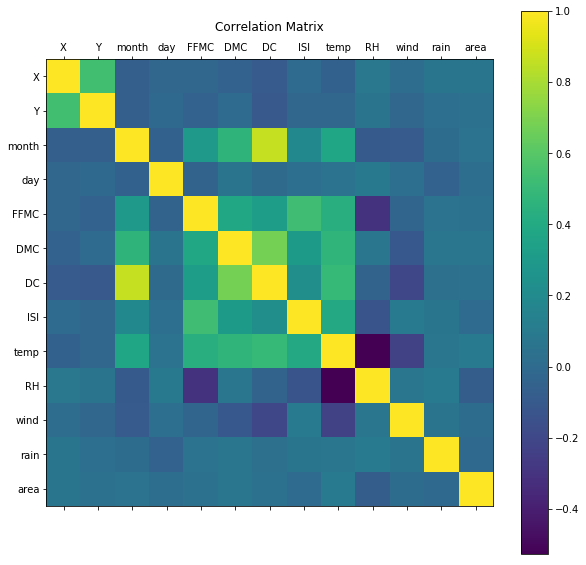

In [182]:
plot_corr(df)

Notamos que el conjunto de datos posee un total de **517** registros con **12** atributos más la variable dependiente, en este caso el área quemada. Los datos contenidos corresponden a: 
1. Datos espaciales: mapeo del terreno a coordenadas $x$ e $y$.
* Datos temporales: día y mes del año.
* Datos del sistema FWI: códigos asociados al material y cantidad de combustible, además de un índice para evaluar la velocidad del fuego.
* Datos meteorológicos: temperatura (°C), humedad relativa (%), velocidad del viento (km/hr) y precipitaciones en (mm/m²).

El área, la variable dependiente, se encuentra expresada en hectáreas (ha).

Además, los autores proponene 4 configuraciones de características para desarrollar los modelos:
1. **STFWI** utilizando los datos espaciales, temporales y FWI.
* **STM** utilizando los datos espaciales, temporales y meteorológicos.
* **FWI**  utilizando solo los datos de este sistema.
* **M** utilizando los datos meteorológicos.

A modo de comparación, se utilizarán de igual forma los datos "crudos".  Para mejorar la capacidad del modelo se utiliza la categorización utilizando la estrategia *1-of-C*.


In [197]:
# Data configurations
STFWI = df.loc[:, ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI']]
#STFWI = pd.get_dummies(STFWI, columns=['month', 'day'])
STM = df.loc[:, ['X', 'Y', 'month', 'day', 'temp', 'RH', 'wind', 'rain']]
#STM = pd.get_dummies(STM, columns=['month', 'day'])
FWI = df.loc[:, ['FFMC', 'DMC', 'DC', 'ISI']]
M = df.loc[:, ['temp', 'RH', 'wind', 'rain']]

# "raw data" X and Y separation
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [198]:
from sklearn.ensemble import ExtraTreesRegressor
# fit an Extra Trees model to the data
model = ExtraTreesRegressor()
model.fit(X, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[  7.27679807e-02   1.02611945e-01   5.77843850e-02   3.83356335e-02
   6.55998387e-02   9.50992350e-02   9.15437641e-02   7.29437516e-02
   1.16839070e-01   1.67420986e-01   1.19046643e-01   6.76703370e-06]


In [199]:
# Train and test split for all data configurations
ts, rs = 0, 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=rs)
STFWI_train, STFWI_test, _, _ = train_test_split(STFWI, y, test_size=ts, random_state=rs)
STM_train, STM_test, _, _ = train_test_split(STM, y, test_size=ts, random_state=rs)
FWI_train, FWI_test, _, _ = train_test_split(FWI, y, test_size=ts, random_state=rs)
M_train, M_test, _, _ = train_test_split(M, y, test_size=ts, random_state=rs)

In [200]:
# Scalers
s1 = StandardScaler().fit(X_train)
s2 = StandardScaler().fit(STFWI_train)
s3 = StandardScaler().fit(STM_train)
s4 = StandardScaler().fit(FWI_train)
s5 = StandardScaler().fit(M_train)

# Pre-processing for all configurations 
X_train_sc = pd.DataFrame(s1.transform(X_train), columns=X_train.columns)
X_train_sc.insert(X_train_sc.shape[1], 'intercept', np.ones(X_train_sc.shape[0]))
STFWI_train_sc = pd.DataFrame(s2.transform(STFWI_train), columns=STFWI_train.columns)
STFWI_train_sc.insert(STFWI_train_sc.shape[1], 'intercept', np.ones(STFWI_train_sc.shape[0]))
STM_train_sc = pd.DataFrame(s3.transform(STM_train), columns=STM_train.columns)
STM_train_sc.insert(STM_train_sc.shape[1], 'intercept', np.ones(STM_train_sc.shape[0]))
FWI_train_sc = pd.DataFrame(s4.transform(FWI_train), columns=FWI_train.columns)
FWI_train_sc.insert(FWI_train_sc.shape[1], 'intercept', np.ones(FWI_train_sc.shape[0]))
M_train_sc = pd.DataFrame(s5.transform(M_train), columns=M_train.columns)
M_train_sc.insert(M_train_sc.shape[1], 'intercept', np.ones(M_train_sc.shape[0]))

Del análisis realizado anteriormente notamos que existe mayor cantidad de incendios "pequeños", es por esto que se sugiere aplicar la transformación logarítmica $y=ln(x+1)$ para incluir un poco de simetría y además escalar considerablemente los datos.

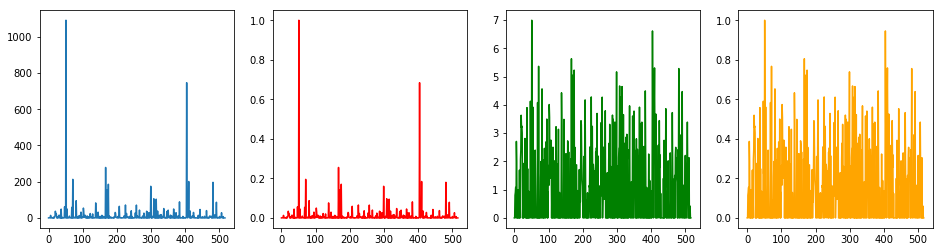

In [201]:
# Normalized target
sy = MinMaxScaler(feature_range=(0, 1))
y_train_sc = sy.fit_transform(y_train.as_matrix().reshape(len(y_train), 1)).flatten()

# Logaritmic target
y_train_log = np.log(y_train + 1)

# Logaritmic normalized
y_train_log_sc = sy.fit_transform(y_train_log.as_matrix().reshape(len(y_train_log), 1)).flatten()

# Comparison plot
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(np.arange(len(y_train)), y_train)
plt.subplot(1, 4, 2)
plt.plot(np.arange(len(y_train_sc)), y_train_sc, 'r')
plt.subplot(1, 4, 3)
plt.plot(np.arange(len(y_train_log)), y_train_log, 'g')
plt.subplot(1, 4, 4)
plt.plot(np.arange(len(y_train_log_sc)), y_train_log_sc, 'orange')
plt.show()

Notamos la clara diferencia en el área una vez que aplicamos la transformación logaritmica.

Para evaluar la calidad de los modelos se utilizaran las méticas: R², MAE y MSE

In [202]:
def printScores(y_real, y_hat):
    print("R²: ", r2_score(y_real, y_hat))
    print("MSE: ", mean_squared_error(y_real, y_hat))
    print("RMSE: ", np.sqrt(mean_squared_error(y_real, y_hat)))
    print("MAE: ", mean_absolute_error(y_real, y_hat))

In [320]:
def checkRFECV(model, dataset, target):
    sel = RFECV(model, step=1, cv=5, scoring='r2')
    sel = sel.fit(dataset, target)
    sel_pos = RFECVInfo(sel, plot=True)
    return sel_pos # Features selected

In [203]:
def RFECVInfo(selector, plot=False):
    print("Optimal number of features : %d" % selector.n_features_)
    print("Best score: ", np.max(selector.grid_scores_))

    if plot:
        # Plot number of features VS. cross-validation scores
        plt.figure(figsize=(10, 6))
        plt.xlabel("Number of features selected")
        plt.ylabel("Cross validation score")
        plt.plot(np.arange(1, 1 + len(selector.grid_scores_)), selector.grid_scores_)
        plt.grid(True)
        plt.show()
    else:
        print("Scores: ", selector.grid_scores_) # Scores
        print("Rankings: ", selector.ranking_) # Ranking
        
    # Get positions of features
    pos = np.argwhere(selector.support_).T[0]
    return pos

In [233]:
def CVScores(model):
    scores = [
        ["Train R²: ", model.cv_results_['mean_train_r2'][model.best_index_]],
        ["Train MSE: ", model.cv_results_['mean_train_neg_mean_squared_error'][model.best_index_]],
        ["Train MAE: ", model.cv_results_['mean_train_neg_mean_absolute_error'][model.best_index_]],
        ["Validation R²: ", model.cv_results_['mean_test_r2'][model.best_index_]],
        ["Validation MSE: ", model.cv_results_['mean_test_neg_mean_squared_error'][model.best_index_]],
        ["Validation MAE: ", model.cv_results_['mean_test_neg_mean_absolute_error'][model.best_index_]]
    ]
    return pd.DataFrame(scores, columns=['Metric', 'Score'])

In [293]:
# Combine all data and targets using GridSearchCV
def GSCVData(model, datasets, targets, parameters, scorers, cv, verbose=False):
    gs_models = []
    best_r2 = -np.inf
    bd, bt, bm, m = 0, 0, 0, 0
    
    # Grid search for every data-target combination
    for d in range(len(datasets)):
        for t in range(len(targets)):
            test_model = GridSearchCV(model, parameters, cv=cv, scoring=scorers, refit='r2', n_jobs=4)
            _ = test_model.fit(datasets[d], targets[t])
            
            if test_model.best_score_ > best_r2:
                best_r2 = test_model.best_score_
                bd, bt, bm = d, t, m
                
            if verbose:
                print(data_labels[d] + ", " + target_labels[t])
                CVScores(test_model)
                print("")
                
            gs_models.append(test_model)
            m += 1
            
    print("Best model configuration:")
    print("Data :", data_labels[bd])
    print("Target: ", target_labels[bt])
    print("Parameters: ", gs_models[bm].best_params_)
    print("CV R²: ", gs_models[bm].best_score_)
    print("")
                
    return gs_models, bd, bt, bm

In [294]:
# Fixed variables

# Data
datasets = [STFWI_train_sc, STM_train_sc, FWI_train_sc, M_train_sc, X_train_sc] # List of datasets tested
targets = [y_train_sc, y_train_log, y_train_log_sc] # List of targets tested

# Labels for naming
data_labels = ["STFWI", "STM", "FWI", "M", "All"]
target_labels = ["Scaled", "Logarithmic", "Logarithmic scaled"]

# Metric scorers
scorers = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Number of K-folds for cross validation
cv_ = 5

## Linear Regression

In [321]:
def searchLR(model, datasets, targets, cv, verbose=False):
    scores = np.zeros((len(datasets), len(targets), 3))
    best_lr_r2 = -np.inf
    bd, bt = 0, 0

    for d in range(len(datasets)):
        for t in range(len(targets)):
            r2 = cross_val_score(model, datasets[d], targets[t], 
                                 cv=cv, scoring='r2', n_jobs=-1)
            mse = cross_val_score(model, datasets[d], targets[t], 
                                  cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
            mae = cross_val_score(model, datasets[d], targets[t], cv=cv, 
                                  scoring='neg_mean_absolute_error', n_jobs=-1)

            scores[d, t, 0] = r2.mean()
            scores[d, t, 1] = mse.mean()
            scores[d, t, 2] = mae.mean()
            
            if scores[d, t, 0] > best_lr_r2:
                best_lr_r2 = scores[d, t, 0]
                bd, bt = d, t

            if verbose:
                print(data_labels[d] + ", " + target_labels[t])
                print("R2: ", scores[d, t, 0])
                print("MSE: ", scores[d, t, 1])
                print("MAE: ", scores[d, t, 2])    
                print("")
        
        print("Best configuration:")
        print(data_labels[bd] + ", " + target_labels[bt])
        print("R²: ", scores[bd, bt, 0])
        print("MSE: ", scores[bd, bt, 1])
        print("MAE: ", scores[bd, bt, 2])    
        print("")
        
        return scores, bd, bt

In [322]:
sc, lr_d , lr_t = searchLR(LR(fit_intercept=False), datasets, targets, cv_)

Best configuration:
STFWI, Logarithmic scaled
R²:  0.00115145259981
MSE:  -0.0396538977315
MAE:  -0.163591274817



Optimal number of features : 4
Best score:  0.0101749932506


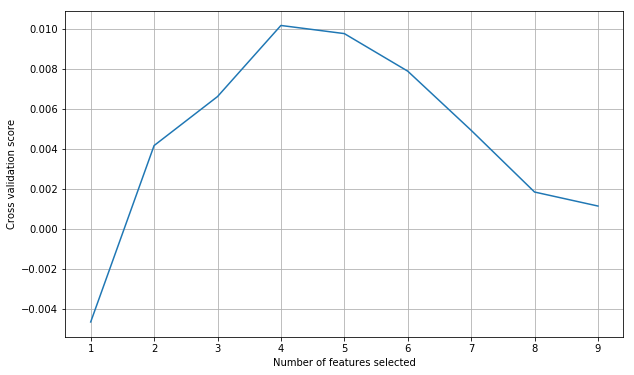

In [326]:
_ = checkRFECV(LR(fit_intercept=False), datasets[lr_d], targets[lr_t])

Luego del análisis realizado anteriormente se concluye lo siguiente:


## SVM

In [289]:
svr_parameters = [
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 'kernel': ['linear']},
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 
         'kernel': ['poly'], 'degree': [3, 4, 5], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
    {'C': [1, 10, 100], 'epsilon': [0.001, 0.01, 0.1], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
 ]

In [291]:
svr_models, svr_d, svr_t, svr_m = GSCVData(SVR(), datasets[:1], targets[:1], svr_parameters, scorers, cv_)

Best model configuration:
Data : STFWI
Target:  Scaled
Parameters:  {'C': 100, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}
CV R²:  -0.00792518663459



In [292]:
CVScores(svr_models[svr_m])

,Metric,Score
0,Train R²:,-0.028055
1,Train MSE:,-0.003479
2,Train MAE:,-0.015962
3,Validation R²:,-0.007925
4,Validation MSE:,-0.003405
5,Validation MAE:,-0.015607


## Decision Trees

In [305]:
dtr_parameters = {
    'criterion': ['mse', 'mae'], 
    'splitter': ['best', 'random'], 
    'max_depth': [10, 50, 100]
}

In [312]:
dtr_models, dtr_d, dtr_t, dtr_m = GSCVData(DTR(), datasets, targets, dtr_parameters, scorers, cv_)

Best model configuration:
Data : FWI
Target:  Logarithmic scaled
Parameters:  {'criterion': 'mse', 'max_depth': 10, 'splitter': 'random'}
CV R²:  -0.247001965052



In [314]:
CVScores(dtr_models[dtr_m])

,Metric,Score
0,Train R²:,0.319445
1,Train MSE:,-0.027089
2,Train MAE:,-0.117053
3,Validation R²:,-0.247002
4,Validation MSE:,-0.049421
5,Validation MAE:,-0.170523


Optimal number of features : 1
Best score:  -0.192380644129


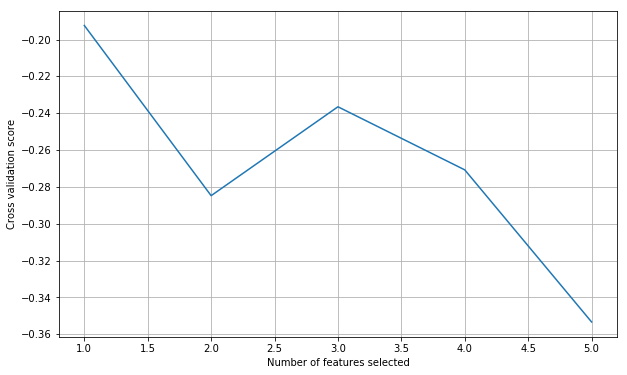

In [328]:
_ = checkRFECV(dtr_models[dtr_m].best_estimator_, datasets[dtr_d], targets[dtr_t])

## Random Forest

In [316]:
rfr_parameters = {
    'n_estimators': [10, 20, 30], 
    'criterion': ['mse', 'mae'], 
    'max_depth': [50, 100]
}

In [317]:
rfr_models, rfr_d, rfr_t, rfr_m = GSCVData(RFR(n_jobs=-1), datasets, targets, rfr_parameters, scorers, cv_)

Best model configuration:
Data : STM
Target:  Logarithmic
Parameters:  {'criterion': 'mae', 'max_depth': 100, 'n_estimators': 20}
CV R²:  -0.0917597108102



In [319]:
CVScores(rfr_models[rfr_m])

,Metric,Score
0,Train R²:,0.782950
1,Train MSE:,-0.423573
2,Train MAE:,-0.502046
3,Validation R²:,-0.091760
4,Validation MSE:,-2.117689
5,Validation MAE:,-1.166563


Optimal number of features : 9
Best score:  -0.0952715155024


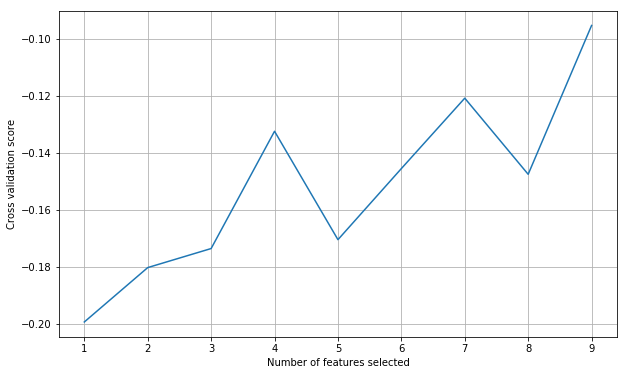

In [329]:
_ = checkRFECV(rfr_models[rfr_m].best_estimator_, datasets[rfr_d], targets[rfr_t])

## Neural Network

In [331]:
nnr_parameters = {
    'hidden_layer_sizes': [(10, ), (20, ), (10, 10)], 
    'activation':  ['identity', 'logistic', 'tanh', 'relu'] ,
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [50, 100, 200],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

In [332]:
nnr_models, nnr_d, nnr_t, nnr_m = GSCVData(MLPR(), datasets, targets, nnr_parameters, scorers, cv_)

KeyboardInterrupt: 

In [117]:
CVScores(all_mlp)

,Metric,Score
0,Train R²:,0.067546
1,Train MSE:,-1.820153
2,Train MAE:,-1.087074
3,Test R²:,0.014495
4,Test MSE:,-1.915642
5,Test MAE:,-1.114355


### Others

In [85]:
from sklearn.ensemble import AdaBoostRegressor

param_grid = {
    "n_estimators": [100, 200]
}

ABC = AdaBoostRegressor(base_estimator=MLPRegressor())

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, cv=cv_, scoring=scorers, refit='r2', n_jobs=-1)
_ = grid_search_ABC.fit(X_train_sc, y_train_sc)
print("Best parameters: ", grid_search_ABC.best_params_)

Best parameters:  {'n_estimators': 100}


In [86]:
CVScores(grid_search_ABC)

,Metric,Score
0,Train R²:,0.197215
1,Train MSE:,-0.002746
2,Train MAE:,-0.042547
3,Test R²:,-7.389992
4,Test MSE:,-0.009432
5,Test MAE:,-0.061519


In [87]:
from sklearn.ensemble import AdaBoostRegressor

param_grid = {
    "base_estimator__criterion" : ["mse", "mae"],
    "base_estimator__splitter" :   ["best", "random"],
    "n_estimators": [100, 200]
}

DTR = DecisionTreeRegressor()
ABC = AdaBoostRegressor(base_estimator=DTR)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, cv=cv_, scoring=scorers, refit='r2', n_jobs=-1)
_ = grid_search_ABC.fit(X_train_sc, y_train_sc)
print("Best parameters: ", grid_search_ABC.best_params_)

Best parameters:  {'base_estimator__criterion': 'mae', 'base_estimator__splitter': 'random', 'n_estimators': 100}


In [88]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = {
    'n_estimators': [50, 100],
    'learning_rate' : [0.001, 0.01, 0.1],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'max_depth': [10, 20, 30],
    'criterion': ['friedman_mse', 'mse', 'mae']
}


est = GradientBoostingRegressor()
gsv = GridSearchCV(est, parameters, cv=cv_, scoring=scorers, refit='r2', n_jobs=-1)
_ = gsv.fit(X_train_sc, y_train_sc)
print("Best parameters: ", gsv.best_params_)

KeyboardInterrupt: 

In [135]:
CVScores(gsv)

,Metric,Score
0,Train R²:,0.180339
1,Train MSE:,-1.599595
2,Train MAE:,-1.048070
3,Test R²:,0.006620
4,Test MSE:,-1.933550
5,Test MAE:,-1.150953


In [143]:
from sklearn.ensemble import ExtraTreesRegressor

ETR = ExtraTreesRegressor(n_estimators=10, max_depth=100)
ETR.fit(X_train_sc, y_train_sc)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=100,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [144]:
ETR.feature_importances_

array([ 0.10911726,  0.09289497,  0.05691186,  0.08921214,  0.07069679,
        0.07784874,  0.08935764,  0.07203849,  0.12026789,  0.09836067,
        0.11830036,  0.00499319,  0.        ])

Numero optimo de features : 9
Scores:  [-0.41147789 -0.40499481 -0.48460246 -0.33226504 -0.27856126 -0.26800522
 -0.28926813 -0.30251659 -0.22889459 -0.28355002 -0.26811361 -0.27329445
 -0.2437    ]
Ranking:  [1 1 3 1 1 1 1 2 1 1 1 4 5]


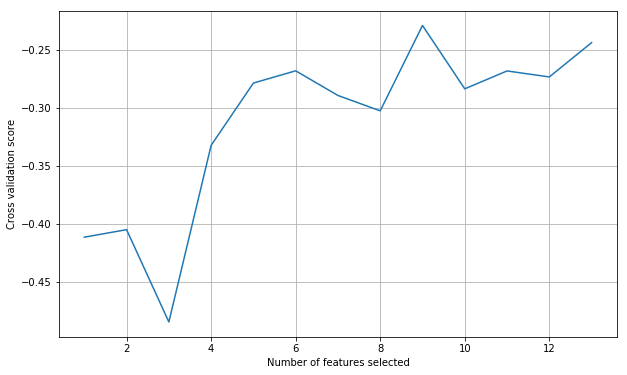

In [145]:
from sklearn.feature_selection import RFECV

ETR = ExtraTreesRegressor(n_estimators=10, max_depth=100)
selector = RFECV(ETR, step=1, cv=5, scoring='r2')
selector = selector.fit(X_train_sc, y_train_sc)

print("Numero optimo de features : %d" % selector.n_features_)
print("Scores: ", selector.grid_scores_) # Puntaje de ajuste
print("Ranking: ", selector.ranking_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(np.arange(1, 1 + len(selector.grid_scores_)), selector.grid_scores_)
plt.grid(True)
plt.show()

In [147]:
pos = np.argwhere(selector.support_).T[0]

[ 0  1  3  4  5  6  8  9 10]


In [149]:
XX_train_sc = X_train_sc.iloc[:, pos]
etr_mse = cross_val_score(ETR, XX_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_squared_error')
etr_mae = cross_val_score(ETR, XX_train_sc, y_train_sc, cv=cv_, scoring='neg_mean_absolute_error')
etr_r2 = cross_val_score(ETR, XX_train_sc, y_train_sc, cv=cv_, scoring='r2')

print("XX")
print("MSE: ", etr_mse.mean())
print("MAE: ", etr_mae.mean())
print("R2: ", etr_r2.mean())

XX
MSE:  -2.52608416496
MAE:  -1.23455416513
R2:  -0.260237508721


In [199]:
from sklearn.decomposition import PCA

PCA = PCA(n_components=8)
XPCA = PCA.fit_transform(X_train_sc)

In [200]:
svr = SVR()
asd = cross_val_score(svr, XPCA, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.187641758446


In [185]:
from sklearn.decomposition import KernelPCA

KPCA = KernelPCA(n_components=10, kernel='rbf')
XKPCA = KPCA.fit_transform(X_train_sc)

In [186]:
mlp = MLPRegressor()
asd = cross_val_score(mlp, XKPCA, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.0221904283831


In [217]:
svr = SVR()
asd = cross_val_score(svr, XPCA, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

(517,)

In [220]:
from sklearn.ensemble import BaggingRegressor

param_grid = {
    "n_estimators": [100, 200]
}

BR = BaggingRegressor(base_estimator=MLPRegressor())

# run grid search
grid_search_BR = GridSearchCV(BR, param_grid=param_grid, cv=cv_, scoring=scorers, refit='r2', n_jobs=-1)
_ = grid_search_BR.fit(X_train_sc, y_train_sc)
print("Best parameters: ", grid_search_BR.best_params_)

Best parameters:  {'n_estimators': 100}


In [221]:
CVScores(grid_search_BR)

,Metric,Score
0,Train R²:,0.170603
1,Train MSE:,-1.619212
2,Train MAE:,-1.030219
3,Test R²:,-0.068353
4,Test MSE:,-2.076392
5,Test MAE:,-1.157568


In [228]:
BE = ExtraTreesRegressor(n_estimators=100, max_depth=100, n_jobs=-1)
BR = BaggingRegressor(base_estimator=BE, n_estimators=100, n_jobs=-1)
asd = cross_val_score(BR, X_train_sc, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.0745248385971


In [238]:
#BE = ExtraTreesRegressor(n_jobs=-1)
BE = MLPRegressor(hidden_layer_sizes=(10, 5, 2))
BR = BaggingRegressor(base_estimator=BE, n_estimators=100, n_jobs=-1)
asd = cross_val_score(BR, X_train_sc, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.0226336569727


In [239]:
from sklearn.feature_selection import RFECV

#BE = ExtraTreesRegressor(n_estimators=100, max_depth=100, n_jobs=-1)
#BR = BaggingRegressor(base_estimator=BE, n_estimators=100, n_jobs=-1)
#RFR = RandomForestRegressor(max_depth=100, n_jobs=-1)
MLP = MLPRegressor(hidden_layer_sizes=(10, 5, 2))
selector = RFECV(MLP, step=1, cv=5, scoring='r2')
selector = selector.fit(X_train_sc, y_train_sc)

print("Numero optimo de features : %d" % selector.n_features_)
print("Scores: ", selector.grid_scores_) # Puntaje de ajuste
print("Ranking: ", selector.ranking_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(np.arange(1, 1 + len(selector.grid_scores_)), selector.grid_scores_)
plt.grid(True)
plt.show()

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [243]:
mlp = MLPRegressor(
    activation='relu', 
    alpha=0.1, 
    batch_size=200, 
    hidden_layer_sizes=(20,), 
    learning_rate='adaptive', 
    solver='sgd'
)

BR = BaggingRegressor(base_estimator=mlp, n_estimators=100, n_jobs=-1)
asd = cross_val_score(BR, X_train_sc, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.0033752193049


In [249]:
lr = LinearRegression(fit_intercept=False)
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()
mlpr = MLPRegressor()
svr = SVR()

# Fit
_ = lr.fit(X_train_sc, y_train_sc)
_ = dtr.fit(X_train_sc, y_train_sc)
_ = rfr.fit(X_train_sc, y_train_sc)
_ = mlpr.fit(X_train_sc, y_train_sc)
_ = svr.fit(X_train_sc, y_train_sc)

In [250]:
# Predict
lrX = lr.predict(X_train_sc)
dtrX = dtr.predict(X_train_sc)
rfrX = rfr.predict(X_train_sc)
mlprX = mlpr.predict(X_train_sc)
svrX = svr.predict(X_train_sc)

In [259]:
new_X = np.array([lrX, dtrX, rfrX, mlprX, svrX]).T

In [261]:
lrb = LinearRegression()
_ = lrb.fit(new_X, y_train_sc)

In [262]:
y_pred = lrb.predict(new_X)
printScores(y_train_sc, y_pred)

R²:  0.992580209921
MSE:  0.0144822466749
RMSE:  0.12034220654
MAE:  0.0189657782804


In [275]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=10)
XPCA = pca.fit_transform(X_train_sc)

In [292]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=3, kernel='rbf')
XKPCA = kpca.fit_transform(X_train_sc)

In [306]:
from sklearn.model_selection import KFold

ns_ = 5
kf = KFold(n_splits=ns_)
#Xm = pd.get_dummies(X_train_sc, columns=['month', 'day']).as_matrix()
Xm = M_train_sc.as_matrix()
ym = y_train_sc.as_matrix()

train_score_cv = 0 
val_score_cv = 0 

for train, val in kf.split(Xm):   
    lr = LinearRegression(fit_intercept=False)
    dtr = DecisionTreeRegressor(max_depth=5)
    rfr = RandomForestRegressor(max_depth=5)
    mlpr = MLPRegressor(hidden_layer_sizes=(10,))
    svr = SVR(kernel='rbf', C=0.001)
    abr = AdaBoostRegressor(n_estimators=100)
    gbr = GradientBoostingRegressor(n_estimators=100)
    etr = ExtraTreesRegressor(n_estimators=100, max_depth=100, n_jobs=-1)

    # Fit
    _ = lr.fit(Xm[train], ym[train])
    _ = dtr.fit(Xm[train], ym[train])
    _ = rfr.fit(Xm[train], ym[train])
    _ = mlpr.fit(Xm[train], ym[train])
    _ = svr.fit(Xm[train], ym[train])
    _ = abr.fit(Xm[train], ym[train])
    _ = gbr.fit(Xm[train], ym[train])
    _ = etr.fit(Xm[train], ym[train])
    
    # Training data
    tr_lrX = lr.predict(Xm[train])
    tr_dtrX = dtr.predict(Xm[train])
    tr_rfrX = rfr.predict(Xm[train])
    tr_mlprX = mlpr.predict(Xm[train])
    tr_svrX = svr.predict(Xm[train])
    tr_abrX = abr.predict(Xm[train])
    tr_gbrX = gbr.predict(Xm[train])
    tr_etrX = etr.predict(Xm[train])
    
    # Validation data
    val_lrX = lr.predict(Xm[val])
    val_dtrX = dtr.predict(Xm[val])
    val_rfrX = rfr.predict(Xm[val])
    val_mlprX = mlpr.predict(Xm[val])
    val_svrX = svr.predict(Xm[val])
    val_abrX = abr.predict(Xm[val])
    val_gbrX = gbr.predict(Xm[val])
    val_etrX = etr.predict(Xm[val])

    trX = np.array([tr_lrX, tr_dtrX, tr_rfrX, tr_mlprX, tr_svrX, tr_abrX, tr_gbrX, tr_etrX]).T
    valX = np.array([val_lrX, val_dtrX, val_rfrX, val_mlprX, val_svrX, val_abrX, val_gbrX, val_etrX]).T
    
    newScaler = StandardScaler()
    trX_sc = newScaler.fit_transform(trX)
    valX_sc = newScaler.transform(valX)
    
    lrb = LinearRegression()
    _ = lrb.fit(trX_sc, ym[train])
    
    train_score_cv += lrb.score(trX_sc, ym[train])
    y_pred = lrb.predict(valX_sc)
    val_score_cv += r2_score(ym[val], y_pred)
    
    
train_score = train_score_cv / ns_
val_score = val_score_cv / ns_
print("Train score: %.4f, Validation Score: %.4f" % (train_score, val_score))

Train score: 0.9518, Validation Score: -0.2594


In [334]:
mlpp = MLPRegressor(hidden_layer_sizes=(1000, 1000, 1000), activation='relu', solver='sgd')
#BR = BaggingRegressor(base_estimator=BE, n_estimators=100, n_jobs=-1)
asd = cross_val_score(mlpp, X_train_sc, y_train_sc, cv=cv_, scoring='r2')
print(asd.mean())

-0.00691269047702


In [330]:
mlpp.fit(X_train_sc, y_train_sc)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(400, 200, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [382]:
from sklearn.feature_selection import RFECV

abr = AdaBoostRegressor(n_estimators=10)
selector = RFECV(abr, step=1, cv=5, scoring='r2')
selector = selector.fit(X_train_sc, y_train_sc)
RFECVInfo(selector)

Numero optimo de features : 8
Scores:  [-0.0886718  -0.10528483 -0.09076473 -0.08130909 -0.08287735 -0.07210675
 -0.08272742 -0.06993005 -0.1066329  -0.08396718 -0.10309468 -0.08094133
 -0.09800879]
Ranking:  [1 4 3 2 1 1 1 1 1 1 1 6 5]
Best score:  -0.069930051217


In [388]:
gbr = GradientBoostingRegressor(n_estimators=5)
selector = RFECV(gbr, step=1, cv=5, scoring='r2')
selector = selector.fit(X_train_sc, y_train_sc)
RFECVInfo(selector)

Numero optimo de features : 1
Scores:  [ 0.00464138  0.00013161 -0.00404227 -0.00281459 -0.00392288 -0.00251181
 -0.00497948 -0.00559415 -0.00546692 -0.00165214 -0.00161958 -0.00588046
 -0.00587182]
Ranking:  [ 5 13  2 10  9  3  4  6  1  8  7 12 11]
Best score:  0.00464137928574


In [389]:
svr = SVR()
abrs = AdaBoostRegressor(base_estimator=svr, n_estimators=10)
selector = RFECV(abrs, step=1, cv=5, scoring='r2')
selector = selector.fit(X_train_sc, y_train_sc)
RFECVInfo(selector)

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [392]:
svr = MLPRegressor()
abrs = AdaBoostRegressor(base_estimator=svr, n_estimators=10)
asd = cross_val_score(abrs, X_train_sc, y_train_sc, cv=cv_, scoring='r2')

In [393]:
print(asd.mean())

-0.257694544413


In [396]:
from sklearn.ensemble import AdaBoostRegressor

param_grid = {
    'base_estimator__hidden_layer_sizes': ((10, ), (20, ), (10, 10)), 
    'base_estimator__activation':  ('identity', 'logistic', 'tanh', 'relu') ,
    'base_estimator__solver': ('lbfgs', 'sgd', 'adam'),
    'base_estimator__alpha': [0.0001, 0.001, 0.01, 0.1],
    'base_estimator__batch_size': [50, 100, 200],
    'base_estimator__learning_rate': ('constant', 'invscaling', 'adaptive'),
    "n_estimators": [10]
}

MLP = MLPRegressor()
ABRMLP = AdaBoostRegressor(base_estimator=MLP)

# run grid search
gs_ABR = GridSearchCV(ABRMLP, param_grid=param_grid, cv=cv_, scoring=scorers, refit='r2', n_jobs=-1)
_ = gs_ABR.fit(X_train_sc, y_train_sc)
print("Best parameters: ", gs_ABR.best_params_)

KeyboardInterrupt: 

In [336]:
import keras

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=600, batch_size=5, verbose=0)

kfold = KFold(n_splits=30, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/dsanmartin/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/dsanmartin/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/dsanmartin/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/dsanmartin/anaconda3/lib/python3.6/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/home/dsanmartin/anaconda3/lib/python3.6/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: /home/dsanmartin/anaconda3/lib/python3.6/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `CXXABI_1.3.11' not found (required by /home/dsanmartin/anaconda3/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so)


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.